# Ribo-seq read length analysis for the all eight groups
<font color='black'> <b>This R code is for the analysis of Ribo-seq read length of genes in all eight gropus as shown in below table. I will analyze all these groups to change in Ribo-seq read lengh preferencial changes in EMT and CX54561 treated samples. <br>
For this analysis I will use differential gene expression data and Ribo-seq read length of genes (code are available in HPC and also Evernote).</font></b>

|TGs|log2(Ctr/TGFB)|log2(TGFB/CX5461)|
|:----|:-------------|:--------------|
|1|up|up|
|2|up|down|
|3|up|Un-changed|
|4|down|up|
|5|down|down|
|6|down|Un-changed|
|7|Un-changed|up|
|8|Un-changed|down|

## <font color='blue'> R library load

In [89]:
suppressMessages(suppressWarnings(source("./jupyter_common.R")))
suppressMessages(suppressWarnings(source("./jupyter_common.R")))
suppressMessages(suppressWarnings(library('readxl')))
suppressMessages(suppressWarnings(library('dplyr')))
suppressMessages(suppressWarnings(library("openxlsx")))
suppressMessages(suppressWarnings(library('rtracklayer')))
suppressMessages(suppressWarnings(library('ggplot2')))
suppressMessages(suppressWarnings(library('data.table')))
suppressMessages(suppressWarnings(library('tidyverse')))

## <font color='blue'>Global parameters

In [83]:
rm(list=ls())
th_adj_pvalue <- 0.05
th_log2fc <- log2(1.2)

## <font color='blue'> Load counts, gene list and GTF files

In [84]:
# Read limma DEG analysis results file
results <- read.xlsx("./xlsx/170224.rdna_rn18s_161021.rdna_rn18s_limma-voom.mrna/170224.rdna_rn18s_161021.rdna_rn18s_limma-voom.mrna_protein_coding.xlsx", sheet = "all", rowNames = TRUE)
results.score <- results[,c('log2FCuntVStgfb.transcription', 'FDRuntVStgfb.transcription', 'log2FCtgfbVStgfbCX5461.transcription', 'FDRtgfbVStgfbCX5461.transcription', 'log2FCuntVStgfb.translation', 'FDRuntVStgfb.translation', 'log2FCtgfbVStgfbCX5461.translation', 'FDRtgfbVStgfbCX5461.translation')]
head(results.score)

# Read GTF file
my_file <- "data/mouse/Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz"
granges_gtf <- import(my_file)

## Read 5' UTR length file
tbl_fread <- 
    list.files(path = "./Read_Lenth/", pattern = "*.length", full.names = TRUE) %>% 
    map_df(~fread(.))
colnames(tbl_fread) <- gsub("Name", "sname", colnames(tbl_fread))
dim(tbl_fread)
head(tbl_fread)

,log2FCuntVStgfb.transcription,FDRuntVStgfb.transcription,log2FCtgfbVStgfbCX5461.transcription,FDRtgfbVStgfbCX5461.transcription,log2FCuntVStgfb.translation,FDRuntVStgfb.translation,log2FCtgfbVStgfbCX5461.translation,FDRtgfbVStgfbCX5461.translation
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009B22Rik,-0.04158431,8.658629e-01,0.254406206,0.47845885,-0.4414281,0.30541555,1.02171324,0.02919136
0610010F05Rik,0.36131693,8.558582e-03,-0.396958965,0.04148518,0.3259794,0.64123254,-0.78689319,0.41800085
0610010K14Rik,-0.65750941,1.465000e-03,-0.118178034,0.79854067,-1.4347083,0.05167993,1.51410985,0.07704533
0610012G03Rik,-0.01120375,9.284910e-01,-0.000463367,0.99821843,-0.5530121,0.13823240,0.01520704,0.98121037
0610030E20Rik,-0.18356050,2.586286e-01,-0.023394823,0.94973859,NA,NA,NA,NA
0610040J01Rik,-3.61580842,1.100000e-10,1.034395317,0.16393562,-0.9502349,0.49047068,-0.14445185,0.95563779


[1] 4141468       4

Gene,Counts,Length,sname
<chr>,<int>,<int>,<chr>
ENSMUST00000000001,2,18,RD0175
ENSMUST00000000001,6,19,RD0175
ENSMUST00000000001,6,20,RD0175
ENSMUST00000000001,9,21,RD0175
ENSMUST00000000001,3,22,RD0175
ENSMUST00000000001,8,23,RD0175


## <font color='blue'> Load design matrix and make condition factor

In [85]:
# Read design matrix
design <- read.table("blancgrp_161021_Riboseq.design.txt.gz")

condition <- ifelse(design$unt48==1, "unt48", ifelse(design$tgfb48==1, "tgfb48", "tgfbCX5461"))
sname <- rownames(design)
name <- paste(sname, condition, sep=".")
extra <- as.data.frame(cbind(sname, condition, name))
head(extra)

,sname,condition,name
,<chr>,<chr>,<chr>
1,RD0175,unt48,RD0175.unt48
2,RD0176,unt48,RD0176.unt48
3,RD0177,unt48,RD0177.unt48
4,RD0178,tgfb48,RD0178.tgfb48
5,RD0179,tgfb48,RD0179.tgfb48
6,RD0180,tgfb48,RD0180.tgfb48


In [86]:
GRCm39.104.gtf <- as.data.frame(granges_gtf)
GRCm39.104.selected <- GRCm39.104.gtf %>%
  rename(Chr=seqnames, ENSG=gene_id, ENST=transcript_id, mol=gene_biotype, Symbol=gene_name) %>%
  select(Chr, mol, ENSG, ENST, Symbol) %>%
  tidyr::drop_na()%>%  #filter(!is.na(ENST)) ##Both filter/is.na will work
  distinct()

colnames(GRCm39.104.selected) <- gsub("ENST","Gene", colnames(GRCm39.104.selected))

tbl_fread <- left_join(tbl_fread, GRCm39.104.selected, by = "Gene")
tbl_fread <- full_join(tbl_fread, extra, by = "sname")
head(tbl_fread)
dim(tbl_fread)

Gene,Counts,Length,sname,Chr,mol,ENSG,Symbol,condition,name
<chr>,<int>,<int>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSMUST00000000001,2,18,RD0175,3,protein_coding,ENSMUSG00000000001,Gnai3,unt48,RD0175.unt48
ENSMUST00000000001,6,19,RD0175,3,protein_coding,ENSMUSG00000000001,Gnai3,unt48,RD0175.unt48
ENSMUST00000000001,6,20,RD0175,3,protein_coding,ENSMUSG00000000001,Gnai3,unt48,RD0175.unt48
ENSMUST00000000001,9,21,RD0175,3,protein_coding,ENSMUSG00000000001,Gnai3,unt48,RD0175.unt48
ENSMUST00000000001,3,22,RD0175,3,protein_coding,ENSMUSG00000000001,Gnai3,unt48,RD0175.unt48
ENSMUST00000000001,8,23,RD0175,3,protein_coding,ENSMUSG00000000001,Gnai3,unt48,RD0175.unt48


[1] 4141468      10

# <font color='blue'> Gene list for all eight groups

## <font color='blue'> Gene differentially expressed in translation
<b>RPG</b>= Ribosome Profiling Group

## <font color='green'> Contol Vs TGFB Translation

#### Control Vs TGFB Translation Up (CtrVsTGFbTranslationUp)

In [95]:
results.score.up <- results.score[(results.score$log2FCuntVStgfb.translation >= th_log2fc & results.score$FDRuntVStgfb.translation <= th_adj_pvalue),]
results.score.up <- results.score.up[,c('log2FCuntVStgfb.translation', 'FDRuntVStgfb.translation')]
CtrVsTGFbTranslationUp <- rownames(na.omit(results.score.up))
length(CtrVsTGFbTranslationUp)

[1] 1138

#### Control Vs TGFB Translation Down (CtrVsTGFbTranslationDn)

In [96]:
results.score.dn <- results.score[(results.score$log2FCuntVStgfb.translation < -th_log2fc & results.score$FDRuntVStgfb.translation <= th_adj_pvalue),]
results.score.dn <- results.score.dn[,c('log2FCuntVStgfb.translation', 'FDRuntVStgfb.translation')]
CtrVsTGFbTranslationDn <- rownames(na.omit(results.score.dn))
length(CtrVsTGFbTranslationDn)

[1] 1113

#### Control Vs TGFB Translation Un-changed (CtrVsTGFbTranslationUn)

In [97]:
results.score.un <- results.score[(abs(results.score$log2FCuntVStgfb.translation) < th_log2fc & results.score$FDRuntVStgfb.translation <= th_adj_pvalue),]
results.score.un <- results.score.un[,c('log2FCuntVStgfb.translation', 'FDRuntVStgfb.translation')]
CtrVsTGFbTranslationUn <- rownames(na.omit(results.score.un))
length(CtrVsTGFbTranslationUn)

[1] 13

## TGFB Vs CX5461 Translation

#### TGFB Vs CX5461 Translation Up (TGFbVsCX5461TranslationUp)

In [98]:
results.score.up <- results.score[(results.score$log2FCtgfbVStgfbCX5461.translation >= th_log2fc & results.score$FDRtgfbVStgfbCX5461.translation <= th_adj_pvalue),]
results.score.up <- results.score.up[,c('log2FCtgfbVStgfbCX5461.translation', 'FDRtgfbVStgfbCX5461.translation')]
TGFbVsCX5461TranslationUp <- rownames(na.omit(results.score.up))
length(TGFbVsCX5461TranslationUp)

[1] 658

#### TGFB Vs CX5461 Translation Down (TGFbVsCX5461TranslationDn)

In [99]:
results.score.dn <- results.score[(results.score$log2FCtgfbVStgfbCX5461.translation <= -th_log2fc & results.score$FDRtgfbVStgfbCX5461.translation <= th_adj_pvalue),]
results.score.dn <- results.score.dn[,c('log2FCtgfbVStgfbCX5461.translation', 'FDRtgfbVStgfbCX5461.translation')]
TGFbVsCX5461TranslationDn <- rownames(na.omit(results.score.dn))
length(TGFbVsCX5461TranslationDn)

[1] 530

#### TGFB Vs CX5461 Translation Un-changed (TGFbVsCX5461TranslationUn)

In [100]:
results.score.un <- results.score[(abs(results.score$log2FCtgfbVStgfbCX5461.translation) < th_log2fc & results.score$FDRtgfbVStgfbCX5461.translation <= th_adj_pvalue),]
results.score.un <- results.score.un[,c('log2FCtgfbVStgfbCX5461.translation', 'FDRtgfbVStgfbCX5461.translation')]
TGFbVsCX5461TranslationUn <- rownames(na.omit(results.score.un))
length(TGFbVsCX5461TranslationUn)

[1] 7

# <font color='blue'> Plot for the length of reads in group wise cpmarisons (total eight comparisons) for the Ribo-seq data
<b> We are looking read length of Ribo-seq, so I will look only translation groups (TrGS) in this analysis. </b>

### <font color='green'> Translation Ctrl.Vs.TGFb-Up and TGFb.Vs.CX5461-Up (TrGS1)

In [101]:
condstr <- "TrGS1"
TrGS1 <- intersect(CtrVsTGFbTranslationUp, TGFbVsCX5461TranslationUp)
verb("(Ctrl.Vs.TGFb-Up) Vs. (TGFb.Vs.CX5461-Up):TrGS1:: %d\n", length(TrGS1))


(Ctrl.Vs.TGFb-Up) Vs. (TGFb.Vs.CX5461-Up):TrGS1:: 65


In [105]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS1] ### TrGS1
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,2.493994,0.10853723,2.602531,2.385456
2,protein_coding,tgfb48,19,2.852388,0.21233301,3.064721,2.640055
3,protein_coding,tgfb48,20,3.452755,0.08664333,3.539398,3.366111
4,protein_coding,tgfb48,21,4.863778,0.18702264,5.050801,4.676756
5,protein_coding,tgfb48,22,2.999599,0.08188493,3.081484,2.917714
6,protein_coding,tgfb48,23,2.048064,0.12653616,2.174600,1.921527


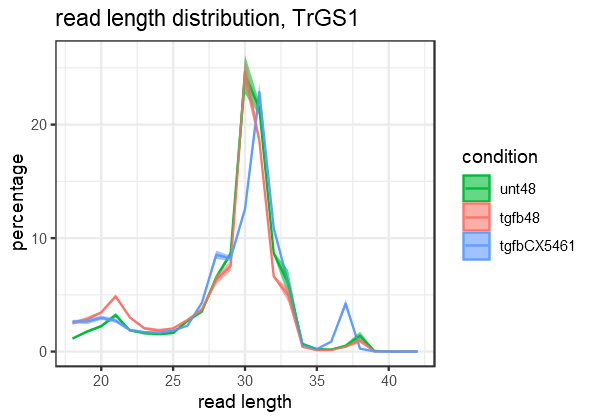

In [111]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'> Translation Ctrl.Vs.TGFb-Up and TGFb.Vs.CX5461-Dn (TrGS2)

In [123]:
condstr <- "TrGS2"
TrGS2 <- intersect(CtrVsTGFbTranslationUp, TGFbVsCX5461TranslationDn)
verb("(Ctrl.Vs.TGFb-Up) Vs. (TGFb.Vs.CX5461-Dn):TrGS2:: %d\n", length(TrGS2))

(Ctrl.Vs.TGFb-Up) Vs. (TGFb.Vs.CX5461-Dn):TrGS2:: 301


In [124]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS2] ### TrGS
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,7.028976,0.2345708,7.263547,6.794405
2,protein_coding,tgfb48,19,8.466416,0.3436588,8.810075,8.122757
3,protein_coding,tgfb48,20,8.928081,0.3711584,9.299239,8.556922
4,protein_coding,tgfb48,21,11.851226,0.3161553,12.167381,11.535070
5,protein_coding,tgfb48,22,7.441145,0.3780275,7.819172,7.063117
6,protein_coding,tgfb48,23,5.028198,0.2324003,5.260599,4.795798


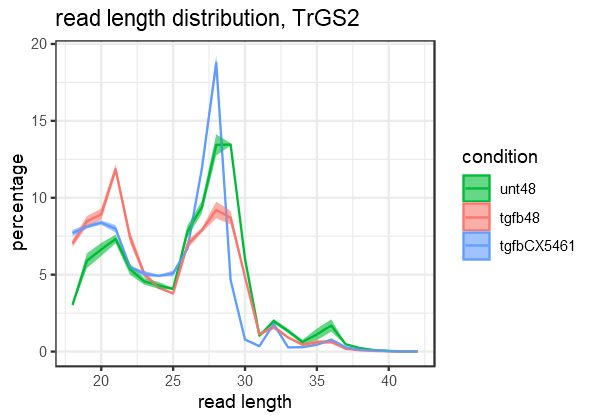

In [125]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'> Translation Ctrl.Vs.TGFb-Up and TGFb.Vs.CX5461-Unchanged (TrGS3)

In [126]:
condstr <- "TrGS3"
TrGS3 <- intersect(CtrVsTGFbTranslationUp, TGFbVsCX5461TranslationUn)
verb("(Ctrl.Vs.TGFb-Up) Vs. (TGFb.Vs.CX5461-Un):TrGS1:: %d\n", length(TrGS3))

(Ctrl.Vs.TGFb-Up) Vs. (TGFb.Vs.CX5461-Un):TrGS1:: 4


In [127]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS3] ### TrGS3
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,7.342434,0.4259949,7.768429,6.916439
2,protein_coding,tgfb48,19,9.054810,0.5421693,9.596980,8.512641
3,protein_coding,tgfb48,20,9.409894,0.4018763,9.811770,9.008018
4,protein_coding,tgfb48,21,13.171064,0.4020261,13.573090,12.769038
5,protein_coding,tgfb48,22,7.582004,0.4187724,8.000776,7.163231
6,protein_coding,tgfb48,23,4.993574,0.5264352,5.520009,4.467139


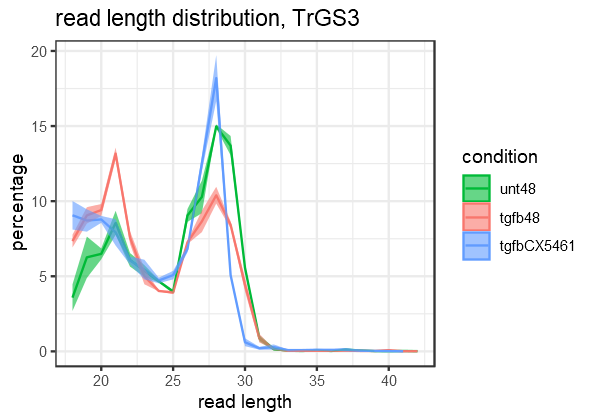

In [128]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'>  Translation Ctrl.Vs.TGFb-Dn and TGFb.Vs.CX5461-Up (TrGS4)

In [129]:
condstr <- "TrGS4"
TrGS4 <- intersect(CtrVsTGFbTranslationDn, TGFbVsCX5461TranslationUp)
verb("(Ctrl.Vs.TGFb-Dn) Vs. (TGFb.Vs.CX5461-Up):TrGS1:: %d\n", length(TrGS4))

(Ctrl.Vs.TGFb-Dn) Vs. (TGFb.Vs.CX5461-Up):TrGS1:: 262


In [130]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS4] ### TrGS4
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,7.541402,0.14983314,7.691235,7.391569
2,protein_coding,tgfb48,19,8.795300,0.20797103,9.003271,8.587329
3,protein_coding,tgfb48,20,9.275008,0.48809110,9.763099,8.786917
4,protein_coding,tgfb48,21,12.078618,0.24751835,12.326136,11.831099
5,protein_coding,tgfb48,22,7.683881,0.20449916,7.888380,7.479382
6,protein_coding,tgfb48,23,5.132708,0.05950974,5.192217,5.073198


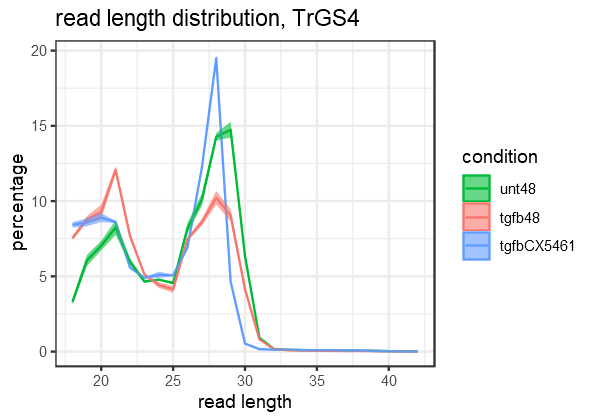

In [131]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'> Translation Ctrl.Vs.TGFb-Dn and TGFb.Vs.CX5461-Dn (TrGS5)

In [132]:
condstr <- "TrGS5"
TrGS5 <- intersect(CtrVsTGFbTranslationDn, TGFbVsCX5461TranslationDn)
verb("(Ctrl.Vs.TGFb-Dn) Vs. (TGFb.Vs.CX5461-Dn):TrGS5:: %d\n", length(TrGS5))

(Ctrl.Vs.TGFb-Dn) Vs. (TGFb.Vs.CX5461-Dn):TrGS5:: 41


In [133]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS5] ### TrGS5
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,13.038180,0.30383372,13.342014,12.734346
2,protein_coding,tgfb48,19,16.003652,0.77642656,16.780078,15.227225
3,protein_coding,tgfb48,20,11.309606,0.04196886,11.351575,11.267637
4,protein_coding,tgfb48,21,10.751050,0.05986748,10.810917,10.691182
5,protein_coding,tgfb48,22,9.203845,0.10303497,9.306880,9.100810
6,protein_coding,tgfb48,23,6.486428,0.05705547,6.543483,6.429372


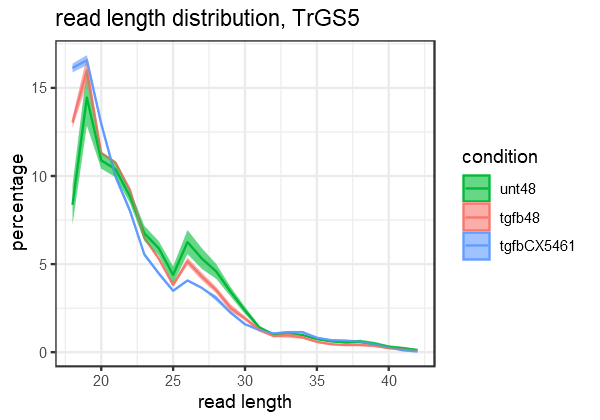

In [134]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'> Translation Ctrl.Vs.TGFb-Dn and TGFb.Vs.CX5461-Un (TrGS6)

In [135]:
condstr <- "TrGS6"
TrGS6 <- intersect(CtrVsTGFbTranslationDn, TGFbVsCX5461TranslationUn)
verb("(Ctrl.Vs.TGFb-Dn) Vs. (TGFb.Vs.CX5461-Un):TrGS6:: %d\n", length(TrGS6))

(Ctrl.Vs.TGFb-Dn) Vs. (TGFb.Vs.CX5461-Un):TrGS6:: 2


In [136]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS6] ### TrGS6
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,7.218051,0.9679688,8.186020,6.250082
2,protein_coding,tgfb48,19,7.574768,0.3688250,7.943593,7.205943
3,protein_coding,tgfb48,20,8.429703,0.7733342,9.203038,7.656369
4,protein_coding,tgfb48,21,12.214773,1.0939770,13.308750,11.120796
5,protein_coding,tgfb48,22,8.086460,0.3543274,8.440787,7.732132
6,protein_coding,tgfb48,23,5.195857,0.7175302,5.913388,4.478327


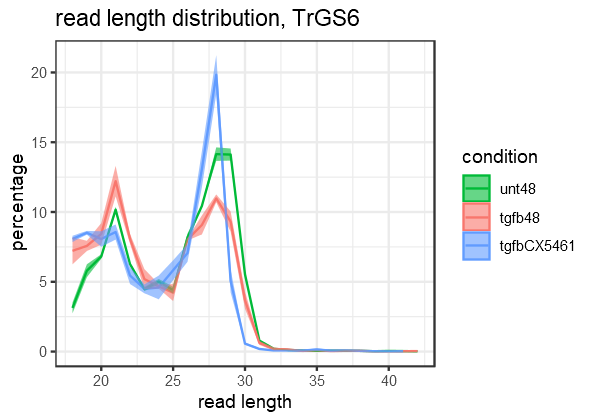

In [137]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'> Translation Ctrl.Vs.TGFb-Un and TGFb.Vs.CX5461-Up (TrGS7)

In [138]:
condstr <- "TrGS7"
TrGS7 <- intersect(CtrVsTGFbTranslationUn, TGFbVsCX5461TranslationUp)
verb("(Ctrl.Vs.TGFb-Un) Vs. (TGFb.Vs.CX5461-Up):TrGS7:: %d\n", length(TrGS7))

(Ctrl.Vs.TGFb-Un) Vs. (TGFb.Vs.CX5461-Up):TrGS7:: 1


In [139]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS7] ### TrGS7
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,7.818421,1.5645381,9.382959,6.253883
2,protein_coding,tgfb48,19,12.001671,2.2779938,14.279665,9.723677
3,protein_coding,tgfb48,20,14.081534,1.7057775,15.787312,12.375756
4,protein_coding,tgfb48,21,13.653240,0.6161064,14.269346,13.037134
5,protein_coding,tgfb48,22,9.504055,2.3997867,11.903842,7.104268
6,protein_coding,tgfb48,23,4.243610,0.7824051,5.026015,3.461205


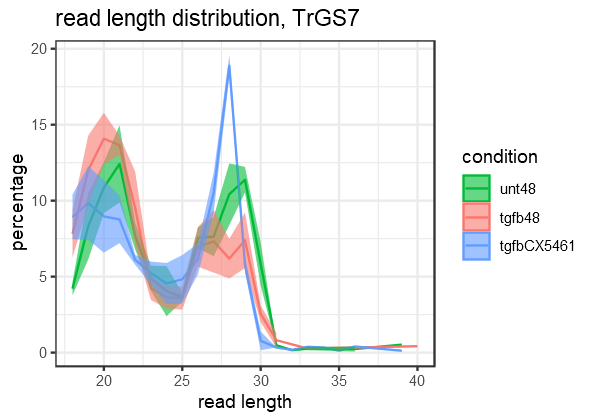

In [140]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))

### <font color='green'> Translation Ctrl.Vs.TGFb-Un and TGFb.Vs.CX5461-Dn (TrGS8)

In [141]:
condstr <- "TrGS8"
TrGS8 <- intersect(CtrVsTGFbTranslationUn, TGFbVsCX5461TranslationDn)
verb("(Ctrl.Vs.TGFb-Un) Vs. (TGFb.Vs.CX5461-Dn):TrGS8:: %d\n", length(TrGS8))

(Ctrl.Vs.TGFb-Un) Vs. (TGFb.Vs.CX5461-Dn):TrGS8:: 5


In [142]:
colnames(tbl_fread) <- gsub("Length", "len", colnames(tbl_fread))
colnames(tbl_fread) <- gsub("Counts", "mult", colnames(tbl_fread))
myData.raw <- tbl_fread[tbl_fread$Symbol %in% TrGS8] ### TrGS8
summ.len  <-  myData.raw  %>%  group_by(name,mol,condition,len)  %>%  summarise(count = sum(mult))
summ.len  <-  summ.len  %>%  group_by(name,mol,condition)  %>%  mutate( perc = count / sum(count)*100 , log2cpm = log2(count) - log2(sum(count)) + log2(1e6) )

### error bar
summ.len.err  <-  summ.len  %>%  group_by(mol,condition,len)  %>%  summarise( mean = mean(perc) , sd = sd(perc) , ymax = mean + sd , ymin = mean - sd )

### cdf
summ.len.cdf  <-  summ.len[ order(summ.len$len) ,]  %>%  group_by(name,mol,condition)  %>%  mutate( cdf = cumsum(perc) )
summ.len.cdf.err  <-  summ.len.cdf  %>%  group_by(mol,condition,len)  %>%  summarise( cdf.mean = mean(cdf) , cdf.sd = sd(cdf) , cdf.ymax = cdf.mean + cdf.sd , cdf.ymin = cdf.mean - cdf.sd )

# df
# by sample
summ.len  <-  as.data.frame(summ.len)
summ.len.cdf  <-  as.data.frame(summ.len.cdf)

# by mol,condition,len
summ.len.err  <-  as.data.frame(summ.len.err)
summ.len.cdf.err  <-  as.data.frame(summ.len.cdf.err)

	protein_coding


,mol,condition,len,mean,sd,ymax,ymin
,<chr>,<ord>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,protein_coding,tgfb48,18,21.508022,0.7377190,22.245741,20.770303
2,protein_coding,tgfb48,19,26.949653,1.7300280,28.679681,25.219625
3,protein_coding,tgfb48,20,7.246800,0.2800881,7.526889,6.966712
4,protein_coding,tgfb48,21,7.140008,0.1781155,7.318124,6.961893
5,protein_coding,tgfb48,22,4.370942,0.1707175,4.541660,4.200224
6,protein_coding,tgfb48,23,2.690392,0.2385058,2.928897,2.451886


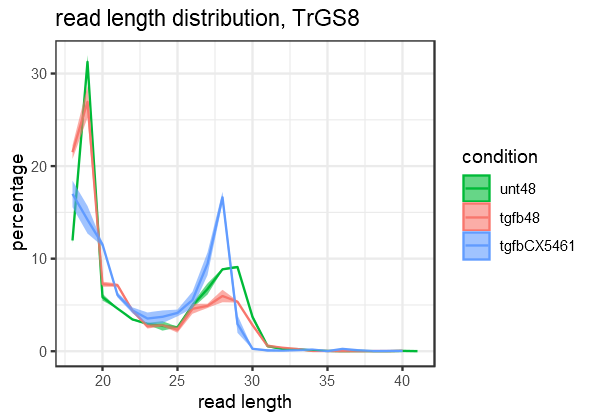

In [143]:
summ.len.err$condition <- as.factor(summ.len.err$condition)
summ.len.err$condition <- ordered(summ.len.err$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ### same order as Hyunsoo Kim
splmol <- split(summ.len.err, summ.len.err$mol)
molx <- "protein_coding"
                                    
verb("\t%s\n", molx)
subdf <- splmol[[molx]]
head(subdf)
#subdf$condition <- ordered(subdf$condition, levels =c("unt48", "tgfb48", "tgfbCX5461")) ## same order as Hyunsoo Kim
gp <- ggplot(data = subdf, aes(x = len, y = mean, ymin = ymin, ymax = ymax, color = condition, fill = condition)) + 
geom_line() + geom_ribbon(alpha = 0.6, aes(linetype = NA)) + 
scale_color_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + scale_fill_manual(values = c("#00BA38", "#F8766D", "#619CFF")) + 
theme_bw() + xlab("read length") + ylab("percentage") + 
ggtitle(sprintf("read length distribution, %s", condstr))
    
print_figure(gp, width = 5, height = 3.5, file = sprintf("Riboseq read length dist_%s", condstr))